In [1]:
import os
import pandas as pd
%matplotlib inline
from dotenv import load_dotenv
from newsapi.newsapi_client import NewsApiClient
import nltk

In C:\Users\markf\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\markf\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\markf\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download("vader_lexicon")

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\markf\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# News Headlines Sentiment

Use the news api to pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [3]:
# Read your api key environment variable
load_dotenv('C:/Users/markf/Desktop/Fintech SMU/API_Keys/.env')

# Set News API Key
api_key = os.getenv("NEWS_API")


In [4]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)


In [5]:
# Defined function to fetch 20 news articles according to topic by relevancy and transform informtion to datafram and filter by article content
def get_articles_df(topic):
    news = newsapi.get_everything(q=topic, language="en", page_size = 20, sort_by = 'relevancy')
    
    articles = []
    for article in news['articles']:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)
    
    return df

In [6]:
# Fetch the Bitcoin news articles
bitcoin_df = get_articles_df('bitcoin').dropna()
bitcoin_df.head()

,date,description,text,title
0,2020-07-17,"On Wednesday, July 15, Twitter was the target ...",Just hackers burning up 0day like it’s a fire ...,Twitter's Bitcoin hackers had almost limitless...
1,2020-07-16,Author’s note: This story was first published ...,Most of these accounts tweeted some variant of...,Everything we know about the Twitter Bitcoin hack
2,2020-07-16,The FBI has confirmed that it’s investigating ...,Reuters had previously reported the FBI would ...,The FBI is investigating the Twitter Bitcoin hack
3,2020-07-18,Ever since Wednesday’s “bitcoin scam” hack whe...,Our investigation and cooperation with law enf...,Twitter confirms 'Bitcoin' hackers copied the ...
4,2020-07-20,The cryptocurrency exchange Coinbase said that...,The company blacklisted the bitcoin address\r\...,"Coinbase says it halted more than $280,000 in ..."


In [7]:
# Fetch the Ethereum news articles
ethereum_df = get_articles_df('ethereum').dropna()
ethereum_df.head()

,date,description,text,title
0,2020-07-22,According to a public letter from the U.S. Com...,According to a public letter from the U.S. Com...,"Banks Can Now Hold Cryptocurrencies, As a Treat"
1,2020-07-01,"When the inventor of AWS Lambda, Tim Wagner, a...","When the inventor of AWS Lambda, Tim Wagner, a...",Vendia raises $5.1M for its multi-cloud server...
2,2020-07-23,Section 230 gives platforms like YouTube broad...,Enlarge/ A screenshot from Wozniak's lawsuit s...,Woz sues YouTube over “bitcoin giveaway” scam ...
6,2020-07-14,"Ethereum, the second most valuable cryptocurre...",Interest in bitcoin and other cryptocurrencies...,Ethereum Is Beating Bitcoin In More Ways Than One
7,2020-07-13,"Lightweight, open-source, universal paper wall...","Lightweight, open-source, universal paper wall...","Lightweight, open-source, universal paper wall..."


In [8]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [9]:
def get_sentiment_scores(df):

    text_sent = {
        "Compound": [],
        "Positive": [],
        "Neutral": [],
        "Negative": [],
        "Sentiment": [],
    }

    # Get sentiment for the text and the title
    for index, row in df.iterrows():
        try:
            text_sentiment = analyzer.polarity_scores(row["text"])
            text_sent["Compound"].append(text_sentiment["compound"])
            text_sent["Positive"].append(text_sentiment["pos"])
            text_sent["Neutral"].append(text_sentiment["neu"])
            text_sent["Negative"].append(text_sentiment["neg"])
            text_sent["Sentiment"].append(get_sentiment(text_sentiment["compound"]))
        except AttributeError:
            pass
    
    sentiment_df = pd.DataFrame(text_sent)
    
    return df.join(sentiment_df)


In [10]:
# Calculate sentiment scores of Bitcoin
bitcoin_sentiment_df = get_sentiment_scores(bitcoin_df)

# Drop unessessary columns
bitcoin_sentiment_df = bitcoin_sentiment_df.drop(columns = ['date', 'description','title'])

In [11]:
# View final dataframe
bitcoin_sentiment_df.head()

,text,Compound,Positive,Neutral,Negative,Sentiment
0,Just hackers burning up 0day like it’s a fire ...,0.0258,0.061,0.880,0.059,0
1,Most of these accounts tweeted some variant of...,0.0000,0.000,1.000,0.000,0
2,Reuters had previously reported the FBI would ...,0.0772,0.038,0.962,0.000,1
3,Our investigation and cooperation with law enf...,0.5994,0.149,0.851,0.000,1
4,The company blacklisted the bitcoin address\r\...,0.1779,0.078,0.866,0.057,1


In [12]:
# Create the ethereum sentiment scores DataFrame
ethereum_sentiment_df = get_sentiment_scores(ethereum_df)

In [13]:
# Drop unessessary columns
ethereum_sentiment_df = ethereum_sentiment_df.drop(columns = ['date', 'description','title'])

In [14]:
# View scores
ethereum_sentiment_df.head(100)

,text,Compound,Positive,Neutral,Negative,Sentiment
0,According to a public letter from the U.S. Com...,0.5719,0.132,0.868,0.000,1.0
1,"When the inventor of AWS Lambda, Tim Wagner, a...",0.2263,0.053,0.947,0.000,1.0
2,Enlarge/ A screenshot from Wozniak's lawsuit s...,-0.6808,0.000,0.823,0.177,-1.0
6,Interest in bitcoin and other cryptocurrencies...,0.5719,0.163,0.780,0.058,1.0
7,"Lightweight, open-source, universal paper wall...",-0.4519,0.060,0.810,0.130,-1.0
8,getty\r\nEvery computer operating system needs...,0.6369,0.136,0.864,0.000,1.0
9,Many who are new to crypto assume that there w...,0.7269,0.186,0.814,0.000,1.0
10,Getty\r\nYou have to use phrases like Ethereum...,0.6808,0.226,0.699,0.075,1.0
11,BITCOIN DASH THE Bitcoin is the original crypt...,0.4019,0.219,0.660,0.121,1.0
12,"If you're into cryptocurrency like Bitcoin, Et...",0.4215,0.083,0.917,0.000,1.0


In [15]:
# Describe the Bitcoin Sentiment
bitcoin_sentiment_df.describe()

,Compound,Positive,Neutral,Negative,Sentiment
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,-0.24647,0.039000,0.870800,0.090200,-0.350000
std,0.42116,0.040217,0.083387,0.084929,0.875094
min,-0.88040,0.000000,0.687000,0.000000,-1.000000
25%,-0.62950,0.000000,0.834250,0.000000,-1.000000
50%,-0.23565,0.038500,0.861500,0.073500,-1.000000
75%,0.03865,0.061750,0.929750,0.145500,0.250000
max,0.59940,0.149000,1.000000,0.277000,1.000000


In [16]:
# Describe the Ethereum Sentiment
ethereum_sentiment_df.describe()

,Compound,Positive,Neutral,Negative,Sentiment
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,0.213693,0.094143,0.858571,0.047357,0.428571
std,0.450407,0.082713,0.102364,0.062552,0.851631
min,-0.680800,0.000000,0.660000,0.000000,-1.000000
25%,0.000000,0.013250,0.811000,0.000000,0.000000
50%,0.314100,0.071500,0.866000,0.000000,1.000000
75%,0.571900,0.156250,0.934250,0.095250,1.000000
max,0.726900,0.226000,1.000000,0.177000,1.000000


### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum

Q: Which coin had the highest compound score?

A: Ethereum

Q. Which coin had the highest positive score?

A: Ethereum

---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [17]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [18]:
# Expand the default stopwords list if necessary

In [19]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [20]:
# Complete the tokenizer function
def tokenizer(text):
    """returns a list of words that is lemmatized, stopworded, tokenized, and free of any non-letter characters. """
    # Create a list of the words
    # Convert the words to lowercase
    # Remove the punctuation
    # Remove the stop words
    # Lemmatize Words into root words
    lemmatizer = WordNetLemmatizer()
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words = word_tokenize(re_clean)
    return [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in set(stopwords.words('english'))]


In [21]:
# Create a new tokens column for bitcoin
bitcoin_sentiment_df['tokens'] = bitcoin_sentiment_df['text'].apply(tokenizer)


In [22]:
bitcoin_sentiment_df.head()

,text,Compound,Positive,Neutral,Negative,Sentiment,tokens
0,Just hackers burning up 0day like it’s a fire ...,0.0258,0.061,0.880,0.059,0,"[hacker, burning, day, like, fire, saleimagine..."
1,Most of these accounts tweeted some variant of...,0.0000,0.000,1.000,0.000,0,"[account, tweeted, variant, message, someone, ..."
2,Reuters had previously reported the FBI would ...,0.0772,0.038,0.962,0.000,1,"[reuters, previously, reported, fbi, would, la..."
3,Our investigation and cooperation with law enf...,0.5994,0.149,0.851,0.000,1,"[investigation, cooperation, law, enforcement,..."
4,The company blacklisted the bitcoin address\r\...,0.1779,0.078,0.866,0.057,1,"[company, blacklisted, bitcoin, addressillustr..."


In [23]:
# Create a new tokens column for ethereum
ethereum_sentiment_df['tokens'] = ethereum_sentiment_df['text'].apply(tokenizer)
ethereum_sentiment_df.head()

,text,Compound,Positive,Neutral,Negative,Sentiment,tokens
0,According to a public letter from the U.S. Com...,0.5719,0.132,0.868,0.000,1.0,"[according, public, letter, u, comptroller, cu..."
1,"When the inventor of AWS Lambda, Tim Wagner, a...",0.2263,0.053,0.947,0.000,1.0,"[inventor, aws, lambda, tim, wagner, former, h..."
2,Enlarge/ A screenshot from Wozniak's lawsuit s...,-0.6808,0.000,0.823,0.177,-1.0,"[enlarge, screenshot, wozniaks, lawsuit, show,..."
6,Interest in bitcoin and other cryptocurrencies...,0.5719,0.163,0.780,0.058,1.0,"[interest, bitcoin, cryptocurrencies, includin..."
7,"Lightweight, open-source, universal paper wall...",-0.4519,0.060,0.810,0.130,-1.0,"[lightweight, opensource, universal, paper, wa..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [24]:
from collections import Counter
from nltk import ngrams

In [25]:
# Extract tokens from dataframe and merge into one list
bitcoin_tokens = [item for sublist in bitcoin_sentiment_df.tokens.to_list() for item in sublist]
ethereum_tokens = [item for sublist in ethereum_sentiment_df.tokens.to_list() for item in sublist]

In [26]:
# define function to look at ngrams top 20
def ngram_counts(corpus): 
    bigram_counts = Counter(ngrams(corpus, n=2))
    top_20 = dict(Counter(bigram_counts).most_common(20))
    return pd.DataFrame(list(top_20.items()), columns=['ngram', 'count'])

In [27]:
# Generate the Bitcoin N-grams where N=2
ngram_counts(bitcoin_tokens)

,ngram,count
0,"(elon, musk)",5
1,"(barack, obama)",4
2,"(bill, gate)",3
3,"(twitter, account)",3
4,"(joe, biden)",3
5,"(send, bitcoin)",2
6,"(bitcoin, scam)",2
7,"(char, image)",2
8,"(kim, kardashian)",2
9,"(kanye, west)",2


In [28]:
# Generate the Ethereum N-grams where N=2
ngram_counts(ethereum_tokens)

,ngram,count
0,"(bitcoin, price)",2
1,"(paper, wallet)",2
2,"(char, bitcoin)",2
3,"(nano, x)",2
4,"(weird, year)",2
5,"(according, public)",1
6,"(public, letter)",1
7,"(letter, u)",1
8,"(u, comptroller)",1
9,"(comptroller, currency)",1


In [29]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    top = dict(Counter(tokens).most_common(N))
    
    return pd.DataFrame(list(top.items()), columns=['word', 'count'])

In [30]:
# Get the top 10 words for Bitcoin
token_count(bitcoin_tokens, 10)

,word,count
0,char,20
1,account,12
2,twitter,11
3,bitcoin,6
4,hacker,5
5,investigation,5
6,scam,5
7,elon,5
8,musk,5
9,would,4


In [31]:
# Get the top 10 words for Ethereum
token_count(ethereum_tokens, 10)

,word,count
0,char,16
1,bitcoin,12
2,ethereum,9
3,wallet,5
4,crypto,4
5,cryptocurrency,4
6,blockchain,3
7,according,2
8,responsible,2
9,system,2


# Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

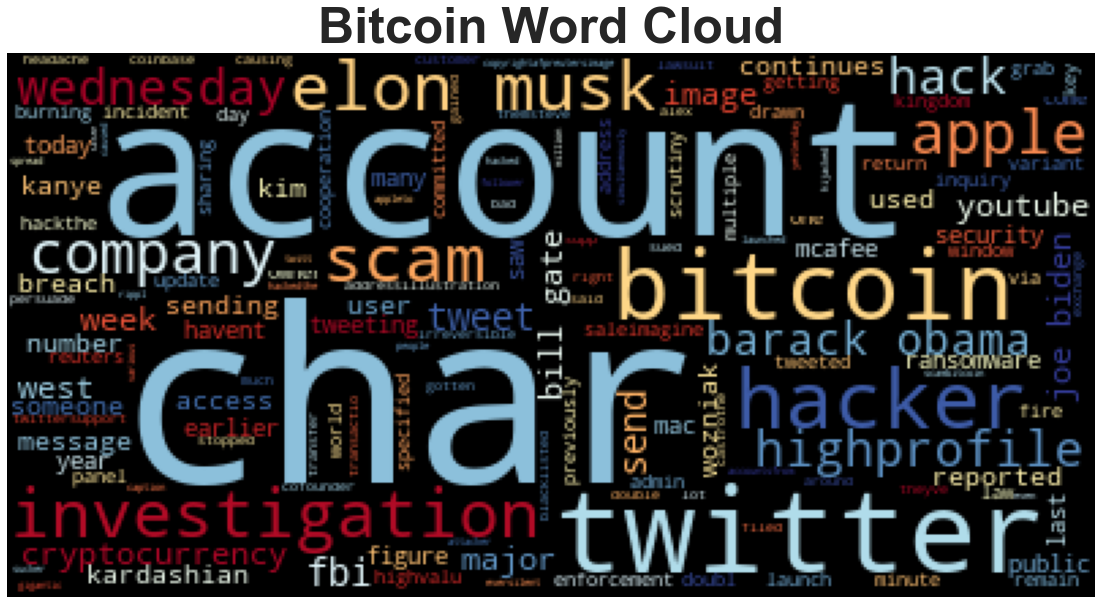

In [33]:
# Generate the Bitcoin word cloud
wordcloud = WordCloud(colormap="RdYlBu").generate(" ".join(bitcoin_tokens))
plt.imshow(wordcloud)
plt.axis("off")
title_font = {"fontsize": 50, "fontweight": "bold"}
plt.title("Bitcoin Word Cloud", fontdict=title_font)
plt.show()

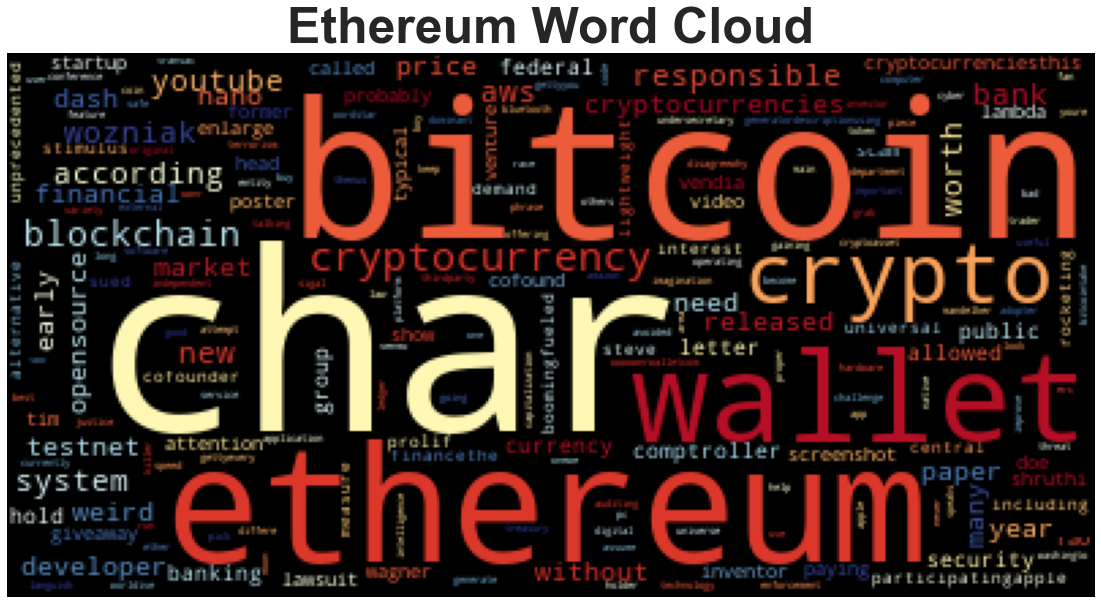

In [34]:
# Generate the Ethereum word cloud
wordcloud = WordCloud(colormap="RdYlBu").generate(" ".join(ethereum_tokens))
plt.imshow(wordcloud)
plt.axis("off")
title_font = {"fontsize": 50, "fontweight": "bold"}
plt.title("Ethereum Word Cloud", fontdict=title_font)
plt.show()

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [35]:
import spacy
from spacy import displacy

In [36]:
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm

In [37]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [46]:
# Concatenate all of the bitcoin text together
bitcoin_text = " ".join(bitcoin_df.text.to_list())
bitcoin_text

"Just hackers burning up 0day like it’s a fire sale\r\nImagine getting the keys to the Twitter kingdom -- access to all the account admin panels in the world. What would you do? You could grab high-valu… [+8860 chars] Most of these accounts tweeted some variant of the same message: If someone were to send Bitcoin to the address specified in the tweets during a 30-minute window, the account owner would return doubl… [+3388 chars] Reuters had previously reported the FBI would launch an investigation into the hack.\r\nThe FBI inquiry is now one of multiple investigations into the incident, which has drawn scrutiny from a number o… [+966 chars] Our investigation and cooperation with law enforcement continues, and we remain committed to sharing any updates here. More to come via @TwitterSupport as our investigation continues.\r\n— Twitter Supp… [+1321 chars] The company blacklisted the bitcoin address\r\nIllustration by Alex Castro\r\nThe cryptocurrency exchange Coinbase said that it stoppe

In [39]:
# Run the NER processor on all of the text
bitcoin_doc = nlp(bitcoin_text)

# Add a title to the document
bitcoin_doc.user_data["title"] = "Bitcoin NER"


In [40]:
# Render the visualization
displacy.render(bitcoin_doc, style='ent')

In [41]:
# List all Entities
for ent in bitcoin_doc.ents:
    print(ent.text, ent.label_)

Twitter ORG
Bitcoin GPE
30-minute TIME
Reuters ORG
FBI ORG
FBI ORG
one CARDINAL
Alex Castro PERSON
Coinbase ORG
around 1,100 CARDINAL
Bitcoin GPE
Apple ORG
YouTube PRODUCT
Steve Wozniak PERSON
this week DATE
YouTube PRODUCT
Twitter ORG
YouTube PRODUCT
Wozniak PERSON
Kanye West GPE
Elon Musk ORG
Bill Gates PERSON
Barack Obama PERSON
FBI ORG
Twitt PERSON
Twitter PERSON
Wednesday DATE
millions CARDINAL
@rippl ORG
Twitters ORG
yesterday DATE
Bill Gates PERSON
Barack Obama PERSON
Appleto PERSON
Twitter ORG
earlier this week DATE
Last week DATE
over 100 CARDINAL
Twitter ORG
today DATE
last week DATE
Twitter ORG
today DATE
2020 DATE
the year DATE
John McAfee
  PERSON
Three years ago DATE
this date DATE
July 17, 2017 DATE
McAfee ORG
ec ORG
San Francisco GPE
CNN ORG
Joe Biden PERSON
Bill Gates PERSON
Elon Musk ORG
Apple ORG
Wednesday DATE
Twitter ORG
earlier this afternoon TIME
Elon Musk ORG
Twitter ORG
Wednesday evening TIME
6 pm ET TIME
Twitter ORG
Apple ORG
Mac ORG
first ORDINAL
Mac ORG
Bara

---

## Ethereum NER

In [42]:
# Concatenate all of the ethereum text together
ethereum_text = " ".join(ethereum_df.text.to_list())
ethereum_text

'According to a public letter from the U.S. Comptroller of the Currency, the federal group responsible for the security of the banking system, banks are now allowed to hold cryptocurrencies.\r\nThis doe… [+1760 chars] When the inventor of AWS Lambda, Tim Wagner, and the former head of blockchain at AWS, Shruthi Rao, co-found a startup, it’s probably worth paying attention. Vendia, as the new venture is called, com… [+4751 chars] Enlarge/ A screenshot from Wozniak\'s lawsuit shows a typical "Bitcoin giveaway" scam video on YouTube.\r\n4 with 4 posters participating\r\nApple co-founder Steve Wozniak has sued YouTube over the prolif… [+3424 chars] Interest in bitcoin and other cryptocurrencies, including ethereum, is boomingfueled by unprecedented central bank stimulus measures and rocketing demand for alternative finance.\r\nThe bitcoin price, … [+3141 chars] Lightweight, open-source, universal paper wallet generator\r\nDescription\r\nUsing third-party services to generate paper wallets 

In [43]:
# Run the NER processor on all of the text
ethereum_doc = nlp(ethereum_text)

# Add a title to the document
ethereum_doc.user_data["title"] = "Ethereum NER"


In [44]:
# Render the visualization
displacy.render(ethereum_doc, style='ent')

In [45]:
# List all Entities
for ent in ethereum_doc.ents:
    print(ent.text, ent.label_)

U.S. GPE
AWS Lambda ORG
Tim Wagner PERSON
Shruthi Rao PERSON
Vendia ORG
Enlarge/ CARDINAL
Wozniak PERSON
Bitcoin GPE
YouTube PRODUCT
4 CARDINAL
4 CARDINAL
Apple ORG
Steve Wozniak PERSON
YouTube ORG
third ORDINAL
WordStar PRODUCT
Apple ORG
one CARDINAL
Getty PERSON
BITCOIN DASH THE Bitcoin ORG
2009 DATE
CRYPTO UNIVERSE Dash PERSON
Bitcoin GPE
two CARDINAL
Bitcoin GPE
Ethereum GPE
ERC20 ORG
The Ledger Nano X Bluetooth WORK_OF_ART
89.25 MONEY
Amazon ORG
Sigal Mandelker PERSON
U.S. Treasury ORG
2018 DATE
the Department of Justice ORG
Bitcoin GPE
a weird year DATE
year DATE
second ORDINAL
Bitcoin GPE
10,000 MONEY
2.0 CARDINAL
Wednesday DATE
end-of-year DATE
August 4 DATE
Medalla PERSON
Nearly $60 million MONEY
June DATE
Dune Analytics ORG
Bitcoin GPE
